In [ ]:
!pip install gym[all]
!pip install gym[accept-rom-license]
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 4.7 MB/s 
     |████████████████████████████████| 3.4 MB 54.9 MB/s 
     |████████████████████████████████| 1.8 MB 53.7 MB/s 
     |████████████████████████████████| 3.5 MB 54.0 MB/s 
     |████████████████████████████████| 18.3 MB 45.0 MB/s 
     |████████████████████████████████| 1.2 MB 60.6 MB/s 
     |████████████████████████████████| 2.1 MB 57.1 MB/s 
     |████████████████████████████████| 296 kB 54.5 MB/s 
     |████████████████████████████████| 1.6 MB 49.2 MB/s 
     |████████████████████████████████| 207 kB 71.2 MB/s 
     |████████████████████████████████| 3.1 MB 53.7 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: pluggy
    Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=48df63a05c2a4931aa6a9b4e0774bf1d048ff1f63f889e62807d6e7c91ed8481
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

from collections import deque
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# replay buffer from and some code based on https://github.com/sfujim/TD3

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u).reshape(-1,1), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

# Environment Wrappers #

In [ ]:
# from: https://github.com/openai/baselines/baselines/common/atari_wrappers.py
# from: https://github.com/Officium/RL-Experiments/blob/master/src/common/wrappers.py 

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [ ]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [ ]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if 0 < lives < self.lives:
            # for Qbert sometimes we stay in lives == 0 condition for a few
            # frames so it's important to keep lives > 0, so that we only reset
            # once the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()

In [ ]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        shape = (2, ) + env.observation_space.shape
        self._obs_buffer = np.zeros(shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = info = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [ ]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    @staticmethod
    def reward(reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = width
        self.height = height
        self.grayscale = grayscale
        shape = (1 if self.grayscale else 3, self.height, self.width)
        self.observation_space = spaces.Box(
            low=0, high=255, shape=shape, dtype=np.uint8
        )

    def observation(self, frame):
        if self.grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        size = (self.width, self.height)
        frame = cv2.resize(frame, size, interpolation=cv2.INTER_AREA)
        if self.grayscale:
            frame = np.expand_dims(frame, -1)
        return frame.transpose((2, 0, 1))

In [ ]:
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also `LazyFrames`
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        shape = (shp[0] * k, ) + shp[1:]
        self.observation_space = spaces.Box(
            low=0, high=255, shape=shape, dtype=env.observation_space.dtype
        )

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return np.asarray(self._get_ob())

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return np.asarray(self._get_ob()), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))


In [ ]:
class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are
        only stored once. It exists purely to optimize memory usage which can be
        huge for DQN's 1M frames replay buffers.
        This object should only be converted to numpy array before being passed
        to the model. You'd not believe how complex the previous solution was.
        """
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-3)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

In [ ]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0
    
    
def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env, width=84, height=84)
    env = MaxAndSkipEnv(env, skip=4)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

# Wrapper Env code ends here  #

# Pong #

In [ ]:
#create Pong env and test it a bit
env = gym.make('PongNoFrameskip-v4')# gym.make("Pong-v0")#gym.make("ALE/Pong-v5") #gym.make("Pong-v0")#('PongNoFrameskip-v4')
env.reset()

for i in range(3000):
    env.render(mode = 'rgb_array')
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    if done:
        env.reset()
env.close()

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.


# Deep Q Network 

In [ ]:
# create Deep Q Network Class by inheriting from torch.nn.Module
# based on Nature CNN from OpenAI baselines: https://github.com/openai/baselines/blob/1b092434fc51efcb25d6650e287f07634ada1e08/baselines/common/models.py
            
class DeepQNetwork(nn.Module):
    def __init__(self, action_size, hidden_size):
        super(DeepQNetwork, self).__init__()
        self.conv_layer_1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv_layer_2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv_layer_3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.dense_layer = nn.Linear(7 * 7 * 64, hidden_size)
        self.out_layer = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = x / 255. # image data is stored as ints in 0 to 255 range. Divide to scale to 0 to 1 range
        x = F.relu(self.conv_layer_1(x))
        x = F.relu(self.conv_layer_2(x))
        x = F.relu(self.conv_layer_3(x))
        x = F.relu(self.dense_layer(x.view(x.size(0), -1)))
        return self.out_layer(x)

# DQNAgent Class

In [ ]:
class DQNAgent():
    def __init__(self, action_size, hidden_size, learning_rate ):
        self.action_size = action_size
        self.train_net = DeepQNetwork(action_size, hidden_size).to(device)
        self.target_net = DeepQNetwork(action_size, hidden_size).to(device)
        self.target_net.load_state_dict(self.train_net.state_dict())
        self.optimizer = optim.Adam(self.train_net.parameters(), lr=learning_rate)

        
    def select_action(self, s, eps):
        # select action according to epsilon-greedy method
        if np.random.rand() <= eps:
            a = env.action_space.sample()
        else:
            # greedy action is the largest Q value from the train network based on the input
            with torch.no_grad():
                input_state = torch.FloatTensor(np.array(s)).unsqueeze(0).to(device)
                a = self.train_net(input_state).max(1)[1]#.view(1, 1)#.detach().cpu().numpy()[0]
                a = int(a)
        return a

    
    def train(self, replay_buffer, batch_size, discount):
        # train the training network
        # sample a batch from the replay buffer
        x0, x1, a, r, d = replay_buffer.sample(batch_size)
        # turn batches into tensors and attack to GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.LongTensor(a).to(device)
        reward_batch = torch.FloatTensor(r).to(device)
        done_batch = torch.FloatTensor(1. - d).to(device)

        # get train net Q values
        train_q = self.train_net(state_batch).gather(1, action_batch)
        
        # get target net Q values
        with torch.no_grad():
            target_net_q = reward_batch + done_batch * discount * \
                     torch.max( self.target_net(next_state_batch).detach(), dim=1)[0].view(batch_size, -1)
            
        # get loss between train q values and target q values
            # DQN implementations typically use MSE loss or Huber loss (smooth_l1_loss is similar to Huber)
        #loss_fn = nn.MSELoss()
        #loss = loss_fn(train_q, target_net_q) 
        loss = F.smooth_l1_loss(train_q, target_net_q)
        
        # optimize the parameters with the loss
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.train_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        # we return the loss so we can monitor loss and debug the network if necessary
        return loss.detach().cpu().numpy()   
    
    
    def update_target_network(self, num_iter, update_every):
        # update target network every so often
        # hard target network update: updates target network fully with train network params
        if num_iter % update_every == 0:
            #print("Updating target network parameters")
            self.target_net.load_state_dict(self.train_net.state_dict())    

# Hyperparameters

In [ ]:
# Initialize env and set up hyperparameters
env = gym.make('PongNoFrameskip-v4')

# wrap env
env = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=False)
action_size = env.action_space.n

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
timesteps = 2000000 # run env for this many time steps
hidden_size = 512   # side of hidden layer of FFNN that connects CNN to outputs
learning_rate = 0.0001 # learning rate of optimizer
batch_size = 32    # size of batch trained on
start_training_after = 10001 # start training NN after this many timesteps
discount = 0.99 # discount future states by

epsilon_start = 1.0 # epsilon greedy start value
epsilon_min = 0.01  # epsilon greedy end value
epsilon_decay_steps = timesteps * .15 # decay epsilon over this many timesteps
epsilon_step = (epsilon_start - epsilon_min)/(epsilon_decay_steps) # decrement epsilon by this amount every timestep

update_target_every = 1000 # update target network every this steps

# create replay buffer
replay_size = 50000 # size of replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)

# create DQN Agent
dqn_agent = DQNAgent(action_size, hidden_size, learning_rate)

# RL Training Loop

In [ ]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
episode = 1
episode_length = 0
stats_loss = 0.
epsilon = epsilon_start
state = env.reset()

for ts in range(timesteps):
    #env.render()
    # select an action from the agent's policy
    action = dqn_agent.select_action(state, epsilon)
    # decay epsilon
    epsilon -= epsilon_step
    if epsilon < epsilon_min:
        epsilon = epsilon_min
            
    # enter action into the env
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    episode_length += 1
    
    # add experience to replay buffer
    replay_buffer.add((state, next_state, action, reward, float(done)))
    
    if ts > start_training_after:
        # train the agent
        stats_loss += dqn_agent.train(replay_buffer, batch_size, discount)
        # update the target network every (if conditions are met in update_target_network)
        dqn_agent.update_target_network(ts, update_target_every)
    
    if done:
        state = env.reset()
        stats_rewards_list.append((episode, total_reward, episode_length))
        episode += 1
        total_reward = 0
        episode_length = 0

        if ts > start_training_after and episode % stats_every == 0:
            print('Episode: {}'.format(episode),
                'Timestep: {}'.format(ts),
                'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                'Epsilon: {:.2f}'.format(epsilon),
                'Loss: {:.4f}'.format(stats_loss))
            stats_loss = 0.
        
        # stopping condition for training if agent reaches the amount of reward
        if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 19:
            print("Stopping at episode {} with average rewards of {} in last {} episodes".
                format(episode, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
            break  
    else:
        state = next_state

Episode: 20 Timestep: 17725 Total reward: -20.0 Episode length: 920.3 Epsilon: 0.94 Loss: 89.6150
Episode: 30 Timestep: 26859 Total reward: -20.4 Episode length: 913.4 Epsilon: 0.91 Loss: 66.7486
Episode: 40 Timestep: 36124 Total reward: -20.2 Episode length: 926.5 Epsilon: 0.88 Loss: 32.6168
Episode: 50 Timestep: 46172 Total reward: -19.8 Episode length: 1004.8 Epsilon: 0.85 Loss: 37.8558
Episode: 60 Timestep: 55410 Total reward: -20.5 Episode length: 923.8 Epsilon: 0.82 Loss: 32.0080
Episode: 70 Timestep: 65478 Total reward: -19.5 Episode length: 1006.8 Epsilon: 0.78 Loss: 35.0032
Episode: 80 Timestep: 77752 Total reward: -18.3 Episode length: 1227.4 Epsilon: 0.74 Loss: 48.4658
Episode: 90 Timestep: 89107 Total reward: -19.4 Episode length: 1135.5 Epsilon: 0.71 Loss: 44.1860
Episode: 100 Timestep: 101954 Total reward: -18.1 Episode length: 1284.7 Epsilon: 0.66 Loss: 53.6568
Episode: 110 Timestep: 114918 Total reward: -18.7 Episode length: 1296.4 Epsilon: 0.62 Loss: 53.8707
Episode: 1

Text(0, 0.5, 'Episode Reward')

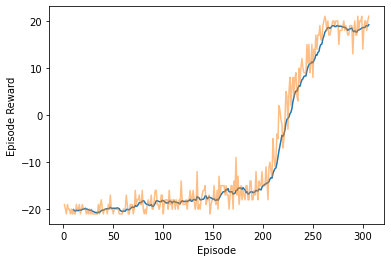

In [ ]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

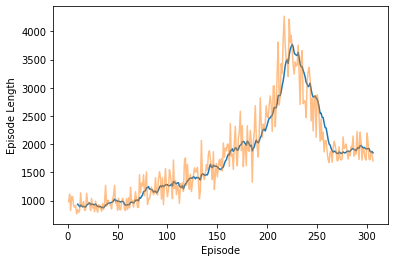

In [ ]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')